In [21]:
import pandas as pd
import numpy as np

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
 
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset
import torch.nn.functional as F
import torch.nn as nn
 
import matplotlib.pyplot as plt
import seaborn as sns

from time import time

In [2]:
batch_size_train = 32
batch_size_val = 32
batch_size_test = 1000

In [3]:
device = torch.device("cuda")

In [4]:
#read the data
train_dataset = pd.read_csv('internship_train.csv')
test_dataset = pd.read_csv('internship_hidden_test.csv')

#shuffle train examples
train_dataset = train_dataset.sample(frac=1).reset_index(drop=True)

In [5]:
#delete one of two highly correlated features ('6' and '8')

train_dataset = train_dataset.drop(['8'], axis=1)
test_dataset = test_dataset.drop(['8'], axis=1)

In [6]:
# split train dataset into train and validation

y = train_dataset[["target"]].to_numpy()
y_train, y_val = y[:75000], y[75000:]

train_dataset = train_dataset.drop(['target'], axis=1).to_numpy()
train_set, val_set = train_dataset[:75000][:], train_dataset[75000:][:]

test_set = test_dataset.to_numpy()

In [7]:
# normalize the data: x -> (x-mean)/std

means = np.mean(train_set, axis=0)
stds = np.std(train_set, axis=0)
train_set = (train_set-means)/stds

means = np.mean(val_set, axis=0)
stds = np.std(val_set, axis=0)
val_set = (val_set-means)/stds

means = np.mean(test_set, axis=0)
stds = np.std(test_set, axis=0)
test_set = (test_set-means)/stds

In [8]:
# create custom dataset classes for train and test data

class TextDataset(Dataset):
    def __init__(self, data, target=np.empty(0)):
        self.data = data
        self.target = target

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if self.target.size > 0:
            return self.data[idx], self.target[idx]
        else:
            return self.data[idx]

In [9]:
train_dataset = TextDataset(train_set, target=y_train)
val_dataset = TextDataset(val_set, target=y_val)
test_dataset = TextDataset(test_set)

train_loader =  torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_train)
val_loader =  torch.utils.data.DataLoader(val_dataset, batch_size=batch_size_val)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size_test)

In [10]:
# define a neural network

class Model(nn.Module):
    def __init__(self, input_dim):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(input_dim, 128)
    
        self.layer2 = nn.Linear(128, 128)
        
        self.layer3 = nn.Linear(128, 128)
        
        self.layer4 = nn.Linear(128, 64)
        
        self.layer5 = nn.Linear(64, 1)
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        
        x = F.relu(self.layer2(x))
        
        x = F.relu(self.layer3(x))
        
        x = F.relu(self.layer4(x))
        
        x = self.layer5(x)
        
        return x

In [11]:
# basically a function that runs a training process for the neural network

def train(model, train_loader, lr):

    time0 = time()

    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9) 
       
    #this scheduler decays the learning rate by gamma every step_size epochs
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)
    
    criterion = nn.MSELoss()

    # the model runs for 50 epochs and then the best weights(in terms of validation
    # loss) are saved
    torch.save(model.state_dict(), 'best_params.pt')
    loss = validate(model, val_loader)
    min_loss = loss

    epochs = 10
    epoch_train_loss = [0]*epochs
    epoch_val_loss = [0]*epochs
   
    train_losses = []
    train_counter = []
    log_interval = 200
    
    for e in range(epochs):
        running_loss = 0
        
        for batch_idx, (data, targets) in enumerate(train_loader):
          
            data, targets = data.to(device), targets.to(device)

            optimizer.zero_grad()
            
            output = model(data.float())
            
            #RMSE loss function
            loss = torch.sqrt(criterion(output, targets.float()))
            
            loss.backward()
            
            optimizer.step()
            
            running_loss += (loss.item() ** 2)
            
            if batch_idx % log_interval == 0:
                train_losses.append(loss.item())
                train_counter.append((batch_idx*batch_size_train) + (e*len(train_loader.dataset)))

        val_loss = validate(model, val_loader)
            
        if val_loss < min_loss:
            min_loss = val_loss
            torch.save(model.state_dict(), 'best_params.pt')

        scheduler.step()
        
        epoch_val_loss[e] = val_loss
        epoch_train_loss[e] = (running_loss/len(train_loader)) ** 0.5
        
        print("Epoch {} \n Training loss : {} \n Validation loss : {}"
              .format(e, epoch_train_loss[e], val_loss))
    
    print("\nTraining Time (minutes) =",(time()-time0)/60)

    model.load_state_dict(torch.load('best_params.pt'))
    
    sns.set(style="whitegrid", font_scale=1.4)

    fig, (ax1, ax2) = plt.subplots(1,2)

    fig.set_figwidth(20)
    fig.set_figheight(7)

    ax1.plot(epoch_train_loss, label='train')
    ax1.plot(epoch_val_loss, label='validation')
    ax2.plot(train_counter, train_losses)
    
    ax1.set(xlabel="Epoch", ylabel="Loss")
    ax2.set(xlabel="Number of training examples seen", ylabel="Loss")
    ax1.legend()


In [12]:
# this function calculates a loss value on the validation dataset

def validate(model, val_loader):
    running_loss = 0
    criterion = nn.MSELoss()

    for data, targets in val_loader:
        with torch.no_grad():
          
            data, targets = data.to(device), targets.to(device)
            
            output = model(data.float())
            
            running_loss += criterion(output, targets.float())
    return (running_loss/len(val_loader)) ** 0.5

In [13]:
model = Model(52)
model.to(device)

Model(
  (layer1): Linear(in_features=52, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=128, bias=True)
  (layer4): Linear(in_features=128, out_features=64, bias=True)
  (layer5): Linear(in_features=64, out_features=1, bias=True)
)

In [14]:
# let's see how the neural network predicts the target before training
# we take only the first batch of data - 32 entries

examples = enumerate(val_loader)
batch_idx, (first_batch_data, first_batch_targets) = next(examples)
first_batch_data, first_batch_targets = first_batch_data.to(device), first_batch_targets.to(device)

output = model(first_batch_data.float()).cpu().detach().numpy()
targets = first_batch_targets.cpu().detach().numpy()

print("Predicted values      Original targets\n")
for i in range(output.size):
    print(output[i], "          ", targets[i])

Predicted values      Original targets

[0.04535509]            [52.42882158]
[0.05517268]            [34.9137244]
[0.04108956]            [26.41675646]
[0.04400947]            [61.5551887]
[0.06475732]            [31.95369426]
[0.03556627]            [95.67221005]
[0.04488102]            [27.29948566]
[0.03676227]            [28.35899323]
[0.03313448]            [82.49575799]
[0.0416291]            [23.58071305]
[0.03440402]            [43.38617301]
[0.06000651]            [70.86211539]
[0.04856983]            [54.31884886]
[0.04728176]            [59.90894449]
[0.0522327]            [33.84108546]
[0.04651822]            [97.25129715]
[0.05524001]            [24.34175193]
[0.04879971]            [50.99102576]
[0.05432946]            [61.17283571]
[0.04516335]            [91.55857152]
[0.04430925]            [72.82240303]
[0.05244826]            [81.15365929]
[0.03856422]            [74.14214305]
[0.02489361]            [97.9368287]
[0.04236137]            [71.04116239]
[0.04326292]   

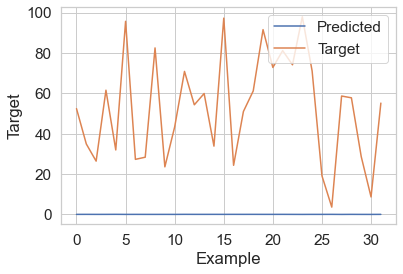

In [15]:
# plot predicted values versus the original targets before training

sns.set(style="whitegrid", font_scale=1.4)

plt.plot(output, label='Predicted')
plt.plot(targets, label='Target')

plt.xlabel("Example")
plt.ylabel("Target")

plt.legend(loc=1)

Epoch 0 
 Training loss : 18.25533113357876 
 Validation loss : 3.0718300342559814
Epoch 1 
 Training loss : 2.8346678970039734 
 Validation loss : 2.127533435821533
Epoch 2 
 Training loss : 0.7672804922219879 
 Validation loss : 0.723784863948822
Epoch 3 
 Training loss : 0.6417000776921037 
 Validation loss : 0.589399516582489
Epoch 4 
 Training loss : 0.49507096293497066 
 Validation loss : 0.5800855159759521
Epoch 5 
 Training loss : 0.48394338776335466 
 Validation loss : 0.5725187659263611
Epoch 6 
 Training loss : 0.47153459818493587 
 Validation loss : 0.5906562805175781
Epoch 7 
 Training loss : 0.4699364266888465 
 Validation loss : 0.5898016095161438
Epoch 8 
 Training loss : 0.4686459034322737 
 Validation loss : 0.5841755270957947
Epoch 9 
 Training loss : 0.4684621510827131 
 Validation loss : 0.584039032459259

Training Time (minutes) = 1.2200270454088846


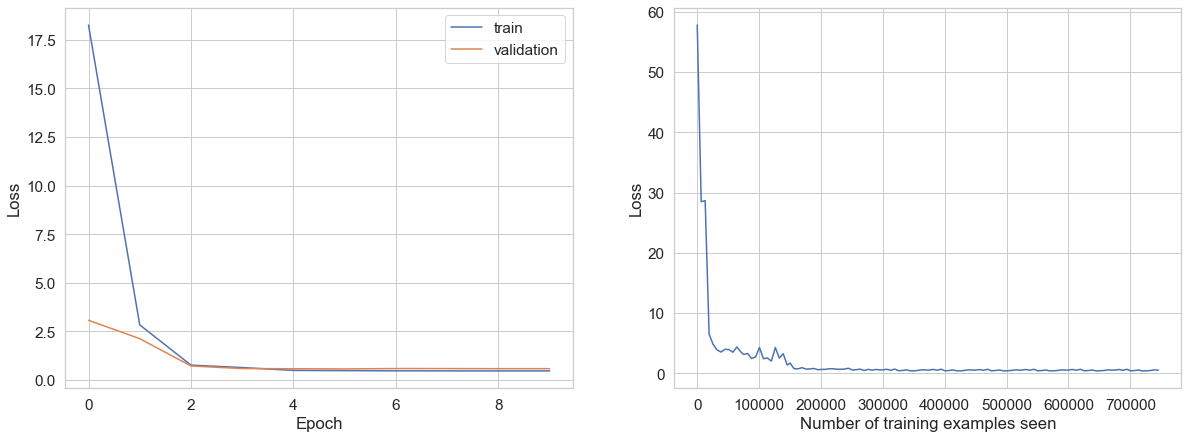

In [16]:
#train the model 

train(model, train_loader, lr=0.001)

In [17]:
# let's see how well the algorithm performs on the validation data after training
# we take only the first batch of data - 32 entries

examples = enumerate(val_loader)
batch_idx, (first_batch_data, first_batch_targets) = next(examples)
first_batch_data, first_batch_targets = first_batch_data.to(device), first_batch_targets.to(device)

output = model(first_batch_data.float()).cpu().detach().numpy()
targets = first_batch_targets.cpu().detach().numpy()

print("Predicted values      Original targets\n")
for i in range(output.size):
    print(output[i], "          ", targets[i])

Predicted values      Original targets

[52.419117]            [52.42882158]
[33.799984]            [34.9137244]
[25.61359]            [26.41675646]
[61.535507]            [61.5551887]
[31.747515]            [31.95369426]
[94.46448]            [95.67221005]
[26.999166]            [27.29948566]
[28.330404]            [28.35899323]
[82.205215]            [82.49575799]
[24.076317]            [23.58071305]
[43.368565]            [43.38617301]
[70.46354]            [70.86211539]
[54.240234]            [54.31884886]
[59.71926]            [59.90894449]
[33.25811]            [33.84108546]
[97.5001]            [97.25129715]
[25.304605]            [24.34175193]
[51.008255]            [50.99102576]
[61.16258]            [61.17283571]
[91.44413]            [91.55857152]
[73.1069]            [72.82240303]
[81.83461]            [81.15365929]
[73.71541]            [74.14214305]
[97.38725]            [97.9368287]
[70.60464]            [71.04116239]
[18.906246]            [19.1609684]
[4.5796666]      

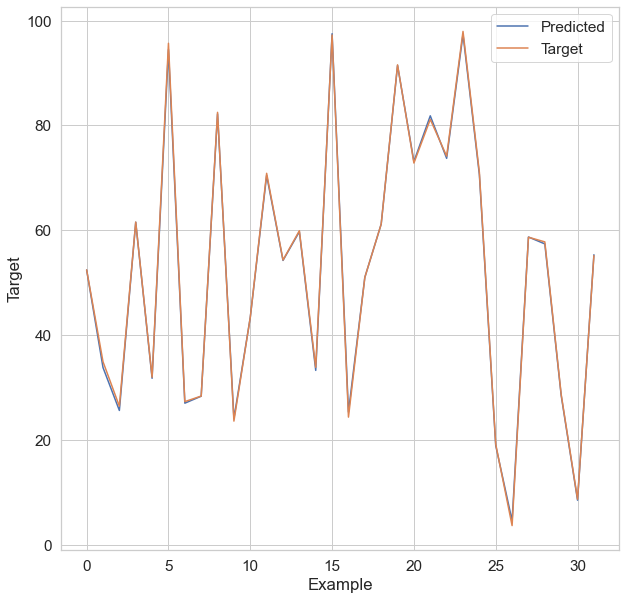

In [18]:
#  plot predicted values versus the original targets before training

sns.set(style="whitegrid", font_scale=1.4)

fig, ax = plt.subplots(figsize=(10, 10))  

plt.plot(output, label='Predicted')
plt.plot(targets, label='Target')

plt.xlabel("Example")
plt.ylabel("Target")

plt.legend(loc=1)

In [19]:
# predict target value for the test dataset

pred = list()

for data in test_loader:
    with torch.no_grad():
        data = data.to(device)
        output = model(data.float()).cpu().detach().numpy()
        pred.append(output)

In [20]:
# write results to a csv file

import csv

with open('Q3_results', 'w') as f:

    for batch in pred:
        for pred_target in batch:
            f.write('%s\n'%pred_target[0])